In [342]:
# function definitions
import torch
from torch import tensor, autograd, sum, linalg, zeros, ones, pow, tril
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time

def L_free(vec):
    """Returns the free particle Lagrangian for vec = torch.cat( (q,qdot,m) )"""
    m = vec[-1]
    vec = vectors[:-1]
    d = int(vec.size()[0]/2)
    qtemp = vec[:d]
    qdottemp = vec[d:]
    return (0.5*m*(qdottemp**2)).sum()
    
def L_harmonic(vec,m=1,k=1):
    """Returns the harmonic oscillator Lagrangian for vec = torch.cat( (q,qdot) )"""
    d = int(vec.size()[0]/2)
    qtemp = vec[:d]
    qdottemp = vec[d:]
    return (0.5*m*(qdottemp**2)).sum() - (0.5*k*(qtemp**2)).sum()

def L_double_pendulum(vec):
    """Returns the double pendulum Lagrangian for vec = torch.cat( (q,qdot) )"""
    d = int(vec.size()[0]/2)
    qtemp = vec[:d]
    qdottemp = vec[d:]
    term1 = ((1/6)*m*l**2)*(qdottemp[1]**2 + 4*qdottemp[0]**2 + 3*qdottemp[0]*qdottemp[1]*torch.cos(qtemp[0] - qtemp[1]) )
    term2 = (.5*m*l*g)*(3*torch.cos(qtemp[0]) + torch.cos(qtemp[1]))
    return term1 + term2

def L_harmonic_plus_charge(vec):
    d = int(vec.size()[0]/2)
    qtemp = vec[:d]
    qdottemp = vec[d:]
    L = (0.5*m*(qdottemp**2)).sum() - (0.5*k*(qtemp**2)).sum()  - 0.5*(p*inv_distances(qtemp).sum(axis=0) ).sum()
    return L

def distances(q,epsillon=1e-12):
    """Returns a matrix where D_{i,j} = distance from particle i to particle j"""
    dim = q.size()[0]
    ones = torch.ones(dim)
    x = torch.outer(q, ones) #x_{i,j} = x_i
    y = torch.outer(ones, q) #y_{i,j} = y_j
    # (x-y)_{i,j} = x_i - y_j
    dist = torch.sqrt( torch.pow((x-y),2) + epsillon**2) #insert epsillon padding to keep distances away from 0 -- prevents derivative blowup
    return dist

def inv_distances(q,power=-1,epsillon=1e-6):
    """Returns a matrix where the lower triangular values iD_{i,j} = 1/(distance from particle i to particle j)"""
    dist = distances(q)
    invdist = torch.pow(dist+epsillon,power) #insert epsillon padding to keep distances away from 0 -- prevents derivative blowup
    invdist = tril(invdist,diagonal=-1)
    return invdist

def qddot(Lag,q,qdot):
    """Returns d^2/dt^2 q given Lagrangian L"""
    v = torch.cat((q,qdot))
    dim = q.size()[0]
    full_hessian = autograd.functional.hessian(Lag,v)
    full_grad = autograd.functional.jacobian(Lag,v)[0]
    """#debug printing functions for testing new Lagrangians
    if torch.isnan(full_hessian).max():
        print("NaN appeared in Hessian! Breaking loop!")
        return "break"
    if torch.isnan(full_grad).max():
        print("NaN appeared in Jacobian! Breaking loop!")
        return "break" """
    
    grad_q = full_grad[:dim]
    hess_q = full_hessian[:dim,:dim]
    hess_qdot = full_hessian[dim:,dim:]
    hess_q_qdot = full_hessian[dim:,:dim]
    qdd = linalg.pinv(hess_qdot)@( grad_q - hess_q_qdot@qdot )
    return qdd

def device_GPU(use_GPU):
    if use_GPU == 1:
        if torch.cuda.is_available():
            dev = torch.device('cuda')
            datatype = torch.double
        else:
            dev = torch.device('cpu')
            datatype = torch.double
            print("CUDA device available! Data reported for CPU only!")
    else:
        dev = torch.device('cpu')
        datatype = torch.double
    return dev, datatype

In [344]:
#plotting functions

import torch
from torch import tensor, autograd, sum, linalg, zeros, ones, pow, tril
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time

def plot_q_qdot_qdd_1d(q,qdot,qddot,iterations,tmax):
    fig, axs = plt.subplots(3,1,figsize = (10,20))
    
    axs[0].plot(np.linspace(0,tmax,iterations),q[:].T,label='q_0')
    axs[0].legend()
    axs[0].set_xlabel('t (sec)')
    axs[0].set_ylabel('q (m)')
    axs[0].set_title('q vs time')
    
    axs[1].plot(np.linspace(0,tmax,iterations),qdot[:].T,label='qdot_0')
    axs[1].legend()
    axs[1].set_xlabel('t (sec)')
    axs[1].set_ylabel('q dot (m/s)')
    axs[1].set_title('q dot vs time')
    
    axs[2].plot(np.linspace(0,tmax,iterations),qddot[:].T,label='qddot_0')
    axs[2].legend()
    axs[2].set_xlabel('t (sec)')
    axs[2].set_ylabel('q double dot (m/s^2)')
    axs[2].set_title('q double dot vs time')

def plot_q_qdot_qdd(q,qdot,qddot):
    qdim = torch.max(tensor(q.size()))
    fig, axs = plt.subplots(3,1,figsize = (10,20))
    for i in range(qdim):
        axs[0].plot(np.linspace(0,tmax,iterations),q_out[i,:].T,label='q_'+str(i))
    axs[0].legend()
    axs[0].set_xlabel('t (sec)')
    axs[0].set_ylabel('q (m)')
    axs[0].set_title('q vs time')
    
    for i in range(qdim):
        axs[1].plot(np.linspace(0,tmax,iterations),qdot_out[i,:].T,label='qdot_'+str(i))
    axs[1].legend()
    axs[1].set_xlabel('t (sec)')
    axs[1].set_ylabel('q dot (m/s)')
    axs[1].set_title('q dot vs time')
    
    for i in range(qdim):
        axs[2].plot(np.linspace(0,tmax,iterations),qddot_out[i,:].T,label='qddot_'+str(i))
    axs[2].legend()
    axs[2].set_xlabel('t (sec)')
    axs[2].set_ylabel('q double dot (m/s^2)')
    axs[2].set_title('q double dot vs time')

In [291]:
def harmonic_demo_1d():
    tmax = 2
    iterations = 1000

    dt = tmax/iterations
    
    dev, datatype = device_GPU(False)
    k = tensor([10], requires_grad = False, dtype=datatype, device = dev)
    m = tensor([1], requires_grad = False, dtype=datatype, device = dev)
    
    q = tensor([1], requires_grad = True, dtype=datatype, device = dev)
    qdot = tensor([0], requires_grad = True, dtype=datatype, device = dev)

    def L_harmonic_demo(vec):
        d = int(vec.size()[0]/2)
        qtemp = vec[:d]
        qdottemp = vec[d:]
        return (0.5*m*(qdottemp**2)).sum() - (0.5*k*(qtemp**2)).sum()
    
    qdim = q.size()[0]
    q_hist = zeros((qdim,iterations), device = dev)
    qdot_hist = zeros((qdim,iterations), device = dev)
    qddot_hist = zeros((qdim,iterations), device = dev)
    
    q_hist[:,0] = q.data
    qdot_hist[:,0] = qdot.data
    qdd = qddot(L_harmonic,q,qdot)
    qdd = (0.5*qddot(L_harmonic_demo,q,qdot) + .5*qddot(L_harmonic_demo,q+dt*qdot, qdot + dt*qdd))/1
    qddot_hist[:,0] = qdd
    
    for i in tqdm.trange(1,iterations):
        q.data += dt*qdot.data
        qdot.data += dt*qdd
        qdd = (.5*qddot(L_harmonic_demo,q,qdot) + .5*qddot(L_harmonic_demo,q+dt*qdot, qdot + dt*qdd))/1
        q_hist[:,i] = q
        qdot_hist[:,i] = qdot
        qddot_hist[:,i] = qdd
    
    q_out = q_hist.cpu().data.detach().numpy()
    qdot_out = qdot_hist.cpu().data.detach().numpy()
    qddot_out = qddot_hist.cpu().data.detach().numpy()

    plot_q_qdot_qdd_1d(q_out,qdot_out,qddot_out,iterations,tmax)

    omega = np.sqrt(k.numpy()/m.numpy())
    E = ((0.5*m*qdot_hist[:,0]**2).sum() + (0.5*k*q_hist[:,0]**2).sum()).detach().numpy()
    A = (torch.sqrt((2/k)*E)).detach().numpy()
    phi = np.arccos(q_out[:,0]/A)
    tgrid = np.arange(0,tmax,dt)
    
    print(A)
    f = A*np.cos(omega*tgrid + phi)
    
    fig, axs = plt.subplots(1,2,figsize=(15,10))
    
    axs[0].plot(tgrid, (f-q_out[0,:].T))
    #axs[0].plot(tgrid, (qdot_out*qddot_out).T/1000)
    axs[0].set_xlabel('t (sec)')
    axs[0].set_ylabel('absolute error')
    axs[0].set_title('Error vs. time')
    
    axs[1].plot(tgrid, f)
    axs[1].set_xlabel('t (sec)')
    axs[1].set_ylabel('q (m)')
    axs[1].set_title('Analytical solution vs. time')
    
    plt.show()



    

In [293]:
def harmonic_demo_n_particles(n):
    tmax = 5
    iterations = 1000

    dt = tmax/iterations
    
    dev, datatype = device_GPU(False)
    k = 10*ones(n, requires_grad = False, dtype=datatype, device = dev)
    m = ones(n, requires_grad = False, dtype=datatype, device = dev)
    
    q = torch.randn(n, requires_grad = True, dtype=datatype, device = dev)
    qdot = torch.randn(n, requires_grad = True, dtype=datatype, device = dev)

    def L_harmonic_demo(vec):
        d = int(vec.size()[0]/2)
        qtemp = vec[:d]
        qdottemp = vec[d:]
        return (0.5*m*(qdottemp**2)).sum() - (0.5*k*(qtemp**2)).sum()

    qdim = q.size()[0]
    q_hist = zeros((qdim,iterations), device = dev)
    qdot_hist = zeros((qdim,iterations), device = dev)
    qddot_hist = zeros((qdim,iterations), device = dev)
    
    q_hist[:,0] = q.data
    qdot_hist[:,0] = qdot.data
    qdd = qddot(L_harmonic,q,qdot)
    qdd = (0.5*qddot(L_harmonic_demo,q,qdot) + .5*qddot(L_harmonic_demo,q+dt*qdot, qdot + dt*qdd))/1
    qddot_hist[:,0] = qdd
    
    for i in tqdm.trange(1,iterations):
        q.data += dt*qdot.data
        qdot.data += dt*qdd
        qdd = (.5*qddot(L_harmonic_demo,q,qdot) + .5*qddot(L_harmonic_demo,q+dt*qdot, qdot + dt*qdd))/1
        q_hist[:,i] = q
        qdot_hist[:,i] = qdot
        qddot_hist[:,i] = qdd
    
    q_out = q_hist.cpu().data.detach().numpy()
    qdot_out = qdot_hist.cpu().data.detach().numpy()
    qddot_out = qddot_hist.cpu().data.detach().numpy()

    plot_q_qdot_qdd_1d(q_out,qdot_out,qddot_out,iterations,tmax)

In [317]:
def harmonic_plus_charge_demo_n_particles(n):
    tmax = 1
    iterations = 10000

    dt = tmax/iterations

    dev, datatype = device_GPU(False)
    k = 10*ones(n, requires_grad = False, dtype=datatype, device = dev)
    m = ones(n, requires_grad = False, dtype=datatype, device = dev)
    #p = 1*(torch.rand(n, requires_grad = True, dtype=datatype, device = dev)-.5)>0
    p = 1*ones(n, requires_grad = False, dtype=datatype, device = dev)

    def L_demo(vec):
        d = int(vec.size()[0]/2)
        qtemp = vec[:d]
        qdottemp = vec[d:]
        L = (0.5*m*(qdottemp**2)).sum() - (0.5*k*(qtemp**2)).sum()  - 0.5*(p*inv_distances(qtemp).sum(axis=0) ).sum()
        return L
    
    q = 5*torch.randn(n, requires_grad = True, dtype=datatype, device = dev)
    qdot = torch.randn(n, requires_grad = True, dtype=datatype, device = dev)

    qdim = q.size()[0]
    q_hist = zeros((qdim,iterations), device = dev)
    qdot_hist = zeros((qdim,iterations), device = dev)
    qddot_hist = zeros((qdim,iterations), device = dev)
    
    q_hist[:,0] = q.data
    qdot_hist[:,0] = qdot.data
    qdd = qddot(L_demo,q,qdot)
    qdd = (0.5*qddot(L_demo,q,qdot) + .5*qddot(L_demo,q+dt*qdot, qdot + dt*qdd))/1
    qddot_hist[:,0] = qdd
    
    for i in tqdm.trange(1,iterations):
        q.data += dt*qdot.data
        qdot.data += dt*qdd
        qdd = (.5*qddot(L_demo,q,qdot) + .5*qddot(L_demo,q+dt*qdot, qdot + dt*qdd))/1
        q_hist[:,i] = q
        qdot_hist[:,i] = qdot
        qddot_hist[:,i] = qdd
    
    q_out = q_hist.cpu().data.detach().numpy()
    qdot_out = qdot_hist.cpu().data.detach().numpy()
    qddot_out = qddot_hist.cpu().data.detach().numpy()

    plot_q_qdot_qdd_1d(q_out,qdot_out,qddot_out,iterations,tmax)

In [545]:
def uniform_B_field_demo_1d():
    tmax = 8
    iterations = 2000

    dt = tmax/iterations
    
    dev, datatype = device_GPU(False)
    m = tensor([1], requires_grad = False, dtype=datatype, device = dev)
    charge = tensor([4], requires_grad = False, dtype=datatype, device = dev)
    B = tensor([4], requires_grad = False, dtype=datatype, device = dev)
    
    q = tensor([.5,0], requires_grad = True, dtype=datatype, device = dev)
    qdot = tensor([0,2], requires_grad = True, dtype=datatype, device = dev)

    def L(vec): #uniform B field
        d = int(vec.size()[0]/2)
        qtemp = vec[:d]
        qdottemp = vec[d:]
        L = (0.5*m*(qdottemp**2)).sum() - 0.5*B*charge*( -1*qdottemp[0]*qtemp[1] + qdottemp[1]*qtemp[0]).sum()
        return L
    
    qdim = q.size()[0]
    q_hist = zeros((qdim,iterations), device = dev)
    qdot_hist = zeros((qdim,iterations), device = dev)
    qddot_hist = zeros((qdim,iterations), device = dev)
    
    q_hist[:,0] = q.data
    qdot_hist[:,0] = qdot.data
    qdd = qddot(L,q,qdot)
    qdd = (0.5*qddot(L,q,qdot) + .5*qddot(L,q+dt*qdot, qdot + dt*qdd))/1
    qddot_hist[:,0] = qdd
    
    for i in tqdm.trange(1,iterations):
        q.data += dt*qdot.data
        qdot.data += dt*qdd
        qdd = (.5*qddot(L,q,qdot) + .5*qddot(L,q+dt*qdot, qdot + dt*qdd))/1
        q_hist[:,i] = q
        qdot_hist[:,i] = qdot
        qddot_hist[:,i] = qdd
    
    q_out = q_hist.cpu().data.detach().numpy()
    qdot_out = qdot_hist.cpu().data.detach().numpy()
    qddot_out = qddot_hist.cpu().data.detach().numpy()


    omega = charge*B/m
    E = ((0.5*m*qdot_hist**2).sum(axis=0)).detach().numpy()
    
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    
    tgrid = np.arange(0,tmax,dt)

    axs[0,0].plot(q_out[0,:] , q_out[1,:])
    axs[0,0].set_xlabel('x')
    axs[0,0].set_ylabel('y')
    axs[0,0].set_title('Position over time')
    
    axs[0,1].plot(tgrid, E-np.mean(E))
    axs[0,1].set_xlabel('t (sec)')
    axs[0,1].set_ylabel('Energy - mean(energy)')
    axs[0,1].set_title('Energy - mean(energy) vs. time')

    axs[1,0].plot(tgrid, (q_out[0,:].T),color='blue',label='x')
    axs[1,0].plot(tgrid, (q_out[1,:].T),color='green',label='y')
    axs[1,0].set_xlabel('t (sec)')
    axs[1,0].set_ylabel('q')
    axs[1,0].set_title('q vs t')
    
    axs[1,1].plot(tgrid, (qdot_out[0,:].T),color='blue',label='x')
    axs[1,1].plot(tgrid, (qdot_out[1,:].T),color='green',label='y')
    axs[1,1].set_xlabel('t (sec)')
    axs[1,1].set_ylabel('qdot')
    axs[1,1].set_title('qdot vs t')
    
    plt.show()



    

100%|██████████| 1999/1999 [00:01<00:00, 1213.83it/s]


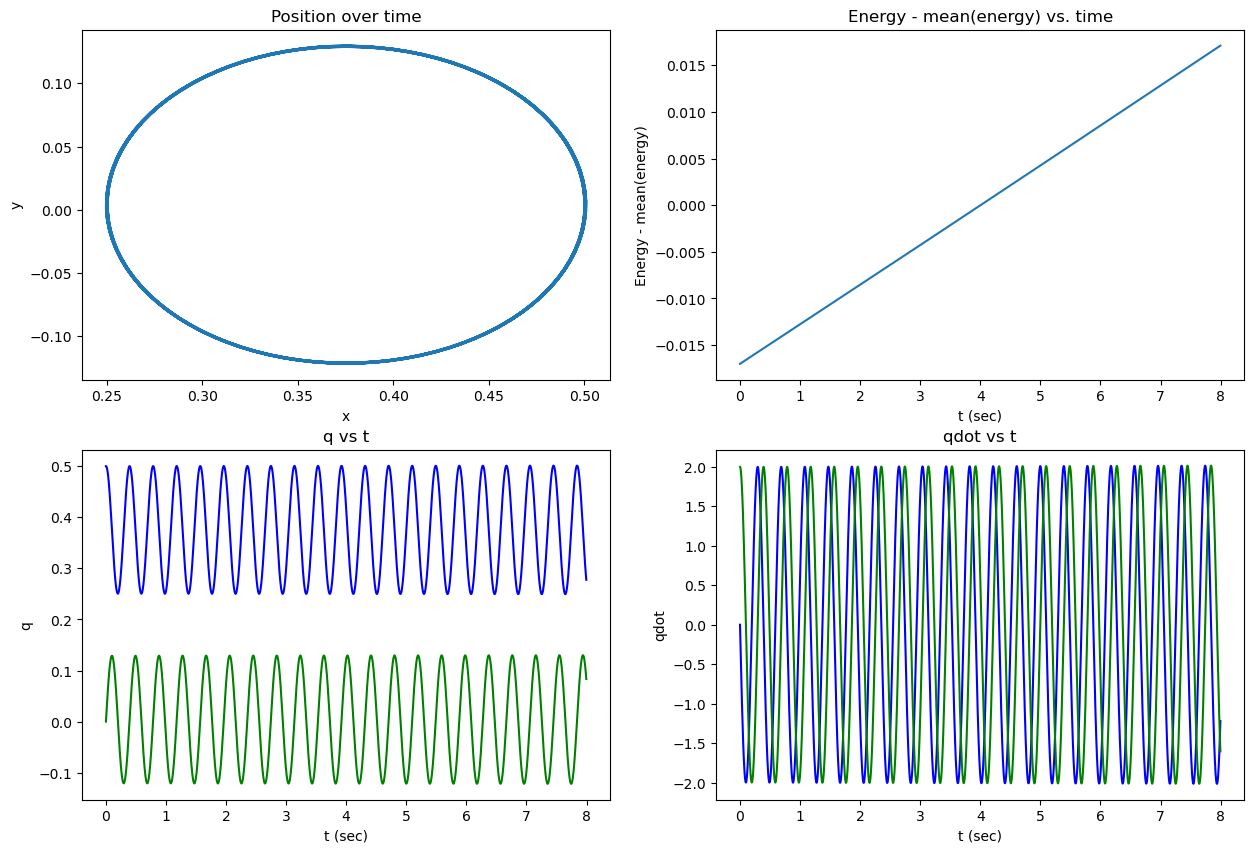

In [547]:
uniform_B_field_demo_1d()

100%|██████████| 9999/9999 [00:43<00:00, 231.20it/s]


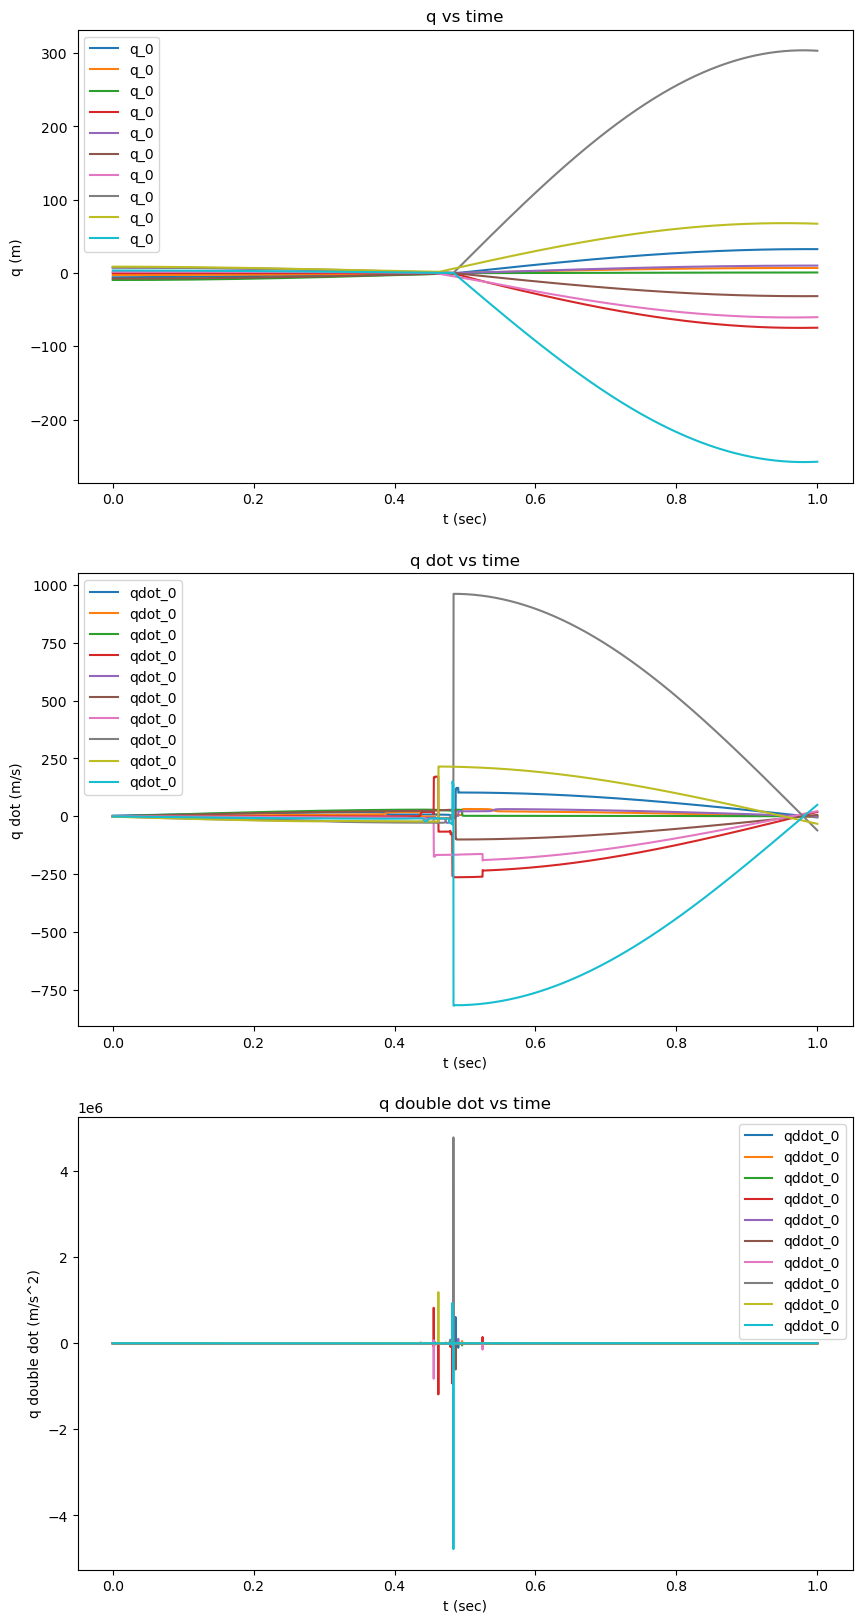

In [319]:
harmonic_plus_charge_demo_n_particles(10)